# Fooling LIME and SHAP
## Analysis (5)

Use different perturbation approaches and compare the impact on being fooled.

In [1]:
import os

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from fooling_LIME_SHAP_Interface.adversarial_model_toolbox import AdversarialModelToolbox
from fooling_LIME_SHAP_Interface.util.explainer_type import ExplainerType
from fooling_LIME_SHAP_Interface.util.ml_type import MLType
from fooling_LIME_SHAP_Interface.perturbator import Perturbator
from fooling_LIME_SHAP_Interface.util.pertubation_method import PerturbationMethod

First we define all the neccessary variables.

In [2]:
TRAIN_TEST_SPLIT = 0.2
SEED = 666

dataset_name = 'HousingData'
input_ids = [5, 7, 11, 12]
categorical_input_ids = []
output_id = 13
biased_id = 11  # B

categorical_input_ids = [input_ids.index(cat_id) for cat_id in categorical_input_ids]
biased_id = input_ids.index(biased_id)

Loading the dataset and doing some preprocessing. There are two datasets. One Dataset is with the biased feature and the other dataset is unbiased because all rows from the biased feature are set to 0.

In [3]:
# Load dataset
house_df = pd.read_csv(os.path.join("datasets", dataset_name + ".csv"))
house_df = house_df.fillna(0)

# Split input and output
y_df = house_df.iloc[:, output_id]
x_df = house_df.iloc[:, input_ids]

scaler = MinMaxScaler()
scaler.fit(x_df.to_numpy())
x = scaler.transform(x_df.to_numpy())

# Create train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y_df.to_numpy(), test_size=TRAIN_TEST_SPLIT, random_state=SEED)

# Create training data without biased column
ux_train = x_train.copy()
ux_train[:, biased_id] = 0
ux_test = x_test.copy()
ux_test[:, biased_id] = 0

Train the biased and unbiased ML model

In [4]:
biased_ml = RandomForestRegressor(random_state=SEED)
biased_ml.fit(x_train, y_train)
print("Accuracy of biased model: {0:3.2}".format(biased_ml.score(x_test, y_test)))

Accuracy of biased model: 0.77


In [5]:
unbiased_ml = RandomForestRegressor(random_state=SEED)
unbiased_ml.fit(ux_test, y_test)
print("Accuracy of unbiased model: {0:3.2}".format(unbiased_ml.score(ux_test, y_test)))

Accuracy of unbiased model: 0.96


## LIME with original pertubation

In [6]:
adv = AdversarialModelToolbox(biased_model=biased_ml, 
                              x_train=x_train, 
                              y_train=y_train, 
                              x_test=x_test, 
                              y_test=y_test,
                              input_feature_names=house_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id,
                              fool_explainer_type=ExplainerType.LIME,
                              ml_type=MLType.REGRESSION, 
                              seed=SEED)

adv.train(perturbator=Perturbator(PerturbationMethod.LIME, perturbation_multiplier=30, seed=SEED))
adv.get_explanations(explanation_sample_number=-1)

Calculating Lime explanations
Original Lime explanation:
{'RM': 4.222782069571837, 'LSTAT': -3.4068982139961905, 'DIS': -1.9202133425684937, 'B': 0.3780400306591363}
Adversarial Lime explanation:
{'LSTAT': -5.017204349246036, 'RM': 2.2636038288798446, 'DIS': -1.3549235542874367, 'B': 0.010346604645831444}
Prediction fidelity between original and adversarial model: 0.75


## LIME with SHAP perturbation

In [7]:
adv = AdversarialModelToolbox(biased_model=biased_ml,
                              x_train=x_train,
                              y_train=y_train,
                              x_test=x_test,
                              y_test=y_test,
                              input_feature_names=house_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id,
                              fool_explainer_type=ExplainerType.LIME,
                              ml_type=MLType.REGRESSION, 
                              seed=SEED)
adv.train(perturbator=Perturbator(PerturbationMethod.SUBSTITUTIONS, perturbation_multiplier=10, seed=SEED))
adv.get_explanations(explanation_sample_number=-1)

Calculating Lime explanations
Original Lime explanation:
{'RM': 4.222782069571837, 'LSTAT': -3.4068982139961905, 'DIS': -1.9202133425684937, 'B': 0.3780400306591363}
Adversarial Lime explanation:
{'LSTAT': -4.872709567923736, 'RM': 2.4724836695451655, 'DIS': -1.700484047613397, 'B': 0.1465400982197728}
Prediction fidelity between original and adversarial model: 0.68


## LIME with PDP perturbation

In [8]:
adv = AdversarialModelToolbox(biased_model=biased_ml,
                              x_train=x_train,
                              y_train=y_train, 
                              x_test=x_test,
                              y_test=y_test,
                              input_feature_names=house_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id,
                              fool_explainer_type=ExplainerType.LIME,
                              ml_type=MLType.REGRESSION, 
                              seed=SEED)
adv.train(perturbator=Perturbator(PerturbationMethod.GRID, perturb_index=biased_id, seed=SEED))
adv.get_explanations(explanation_sample_number=-1)

Calculating Lime explanations
Original Lime explanation:
{'RM': 4.222782069571837, 'LSTAT': -3.4068982139961905, 'DIS': -1.9202133425684937, 'B': 0.3780400306591363}
Adversarial Lime explanation:
{'LSTAT': -5.049108739822424, 'RM': 2.2467521256361143, 'DIS': -1.3440780038060998, 'B': 0.026155983850753343}
Prediction fidelity between original and adversarial model: 0.098


## SHAP with LIME perturbation

Calculating Shap explanations


  0%|          | 0/101 [00:00<?, ?it/s]

Original Shap explanation:


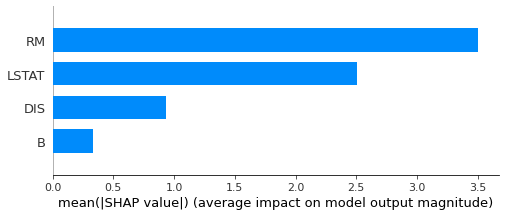

  0%|          | 0/101 [00:00<?, ?it/s]

Adversarial Shap explanation:


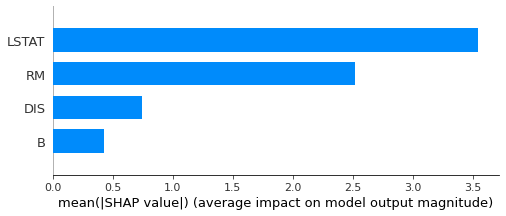

Prediction fidelity between original and adversarial model: 0.75


In [9]:
adv = AdversarialModelToolbox(biased_model=biased_ml,
                              x_train=x_train, 
                              y_train=y_train, 
                              x_test=x_test, 
                              y_test=y_test,
                              input_feature_names=house_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id,
                              fool_explainer_type=ExplainerType.SHAP,
                              ml_type=MLType.REGRESSION,
                              seed=SEED)
adv.train(perturbator=Perturbator(PerturbationMethod.LIME, perturbation_multiplier=30, seed=SEED))
adv.get_explanations(explanation_sample_number=-1)

## SHAP with original perturbation

Calculating Shap explanations


  0%|          | 0/101 [00:00<?, ?it/s]

Original Shap explanation:


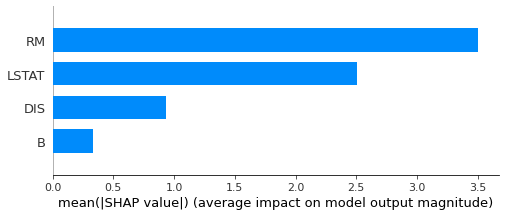

  0%|          | 0/101 [00:00<?, ?it/s]

Adversarial Shap explanation:


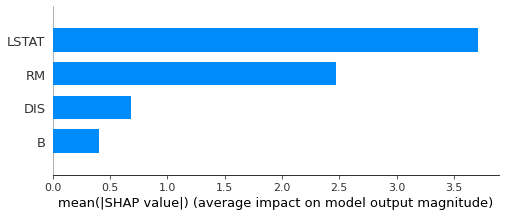

Prediction fidelity between original and adversarial model: 0.68


In [10]:
adv = AdversarialModelToolbox(biased_model=biased_ml,
                              x_train=x_train, 
                              y_train=y_train, 
                              x_test=x_test, 
                              y_test=y_test,
                              input_feature_names=house_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id, 
                              fool_explainer_type=ExplainerType.SHAP,
                              ml_type=MLType.REGRESSION, 
                              seed=SEED)
adv.train(perturbator=Perturbator(PerturbationMethod.SUBSTITUTIONS, perturbation_multiplier=10, seed=SEED))
adv.get_explanations(explanation_sample_number=-1)

## SHAP with PDP perturbation

Calculating Shap explanations


  0%|          | 0/101 [00:00<?, ?it/s]

Original Shap explanation:


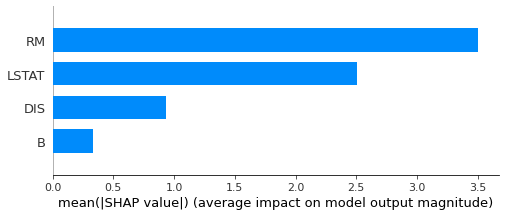

  0%|          | 0/101 [00:00<?, ?it/s]

Adversarial Shap explanation:


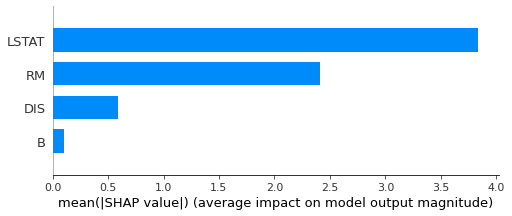

Prediction fidelity between original and adversarial model: 0.098


In [11]:
adv = AdversarialModelToolbox(biased_model=biased_ml, 
                              x_train=x_train, 
                              y_train=y_train, 
                              x_test=x_test, 
                              y_test=y_test,
                              input_feature_names=house_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id, 
                              fool_explainer_type=ExplainerType.SHAP,
                              ml_type=MLType.REGRESSION, 
                              seed=SEED)
adv.train(perturbator=Perturbator(PerturbationMethod.GRID, perturb_index=biased_id, seed=SEED))
adv.get_explanations(explanation_sample_number=-1)

## PDP with LIME perturbation

Calculating PDP explanations
Original PDP explanation:


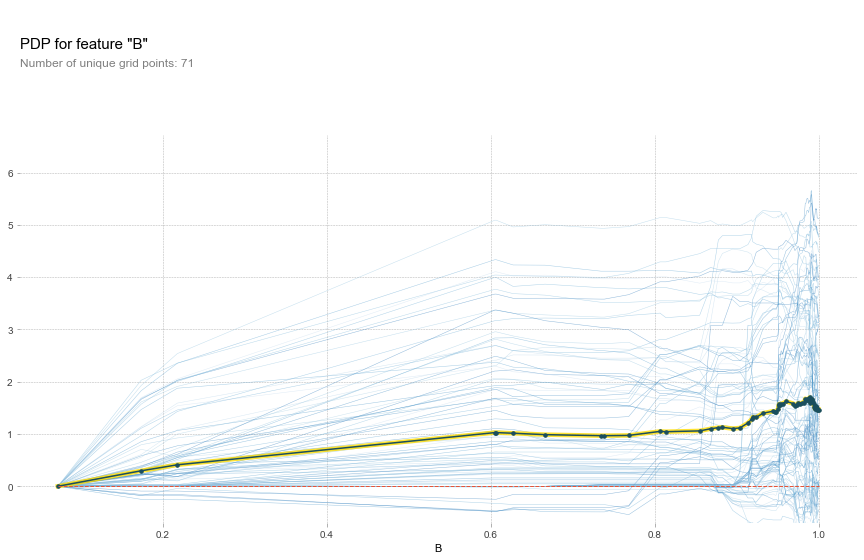

Adversarial PDP explanation:


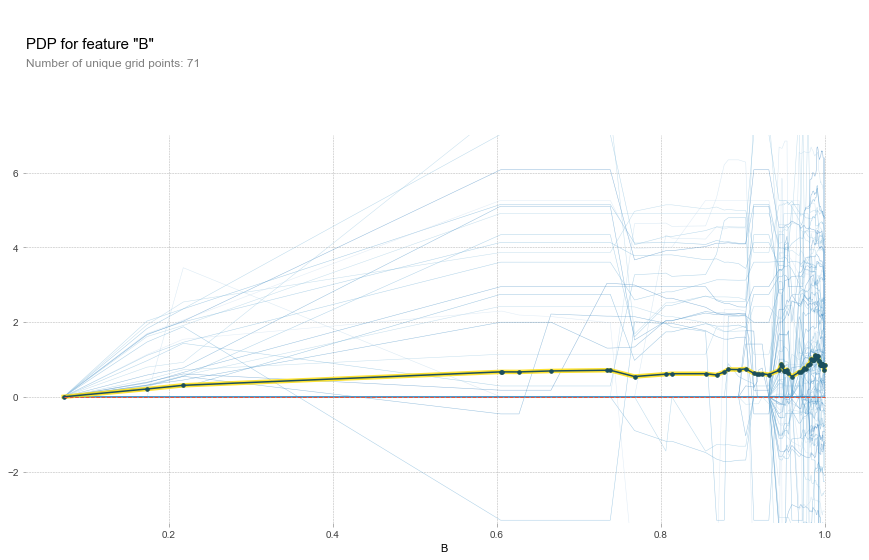

Prediction fidelity between original and adversarial model: 0.75


In [12]:
adv = AdversarialModelToolbox(biased_model=biased_ml,
                              x_train=x_train,
                              y_train=y_train,
                              x_test=x_test, 
                              y_test=y_test,
                              input_feature_names=house_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id,
                              fool_explainer_type=ExplainerType.PDP,
                              ml_type=MLType.REGRESSION, 
                              seed=SEED)
adv.train(perturbator=Perturbator(PerturbationMethod.LIME, perturbation_multiplier=30, seed=SEED))
adv.get_explanations(explanation_sample_number=-1)

## PDP with SHAP perturbation

Calculating PDP explanations
Original PDP explanation:


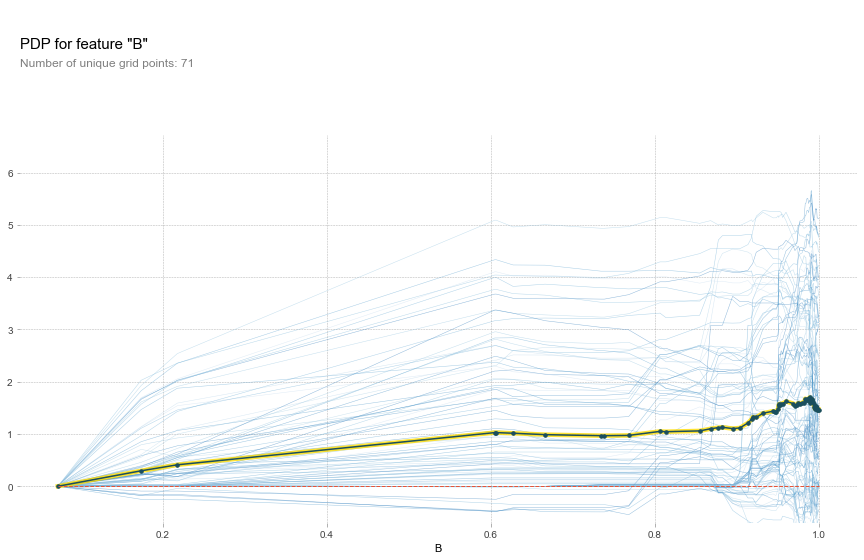

Adversarial PDP explanation:


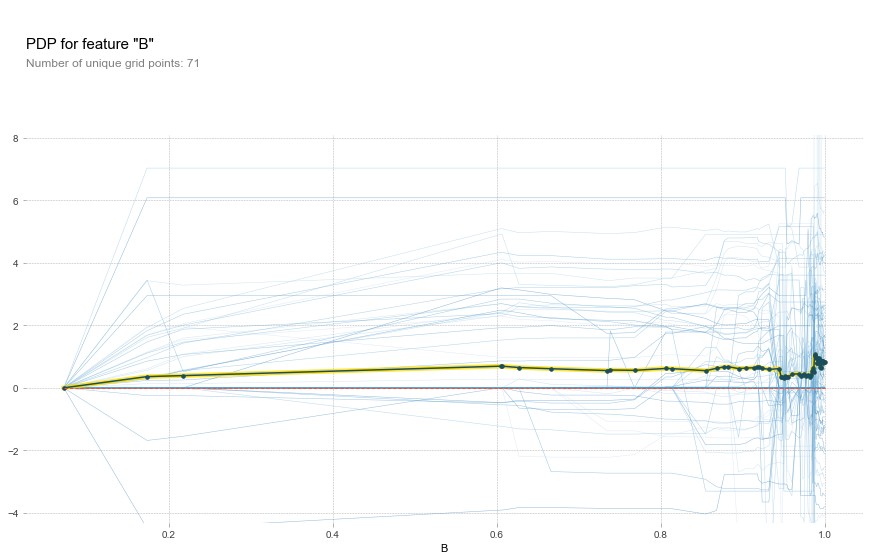

Prediction fidelity between original and adversarial model: 0.68


In [13]:
adv = AdversarialModelToolbox(biased_model=biased_ml, 
                              x_train=x_train, 
                              y_train=y_train, 
                              x_test=x_test, 
                              y_test=y_test,
                              input_feature_names=house_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id, 
                              fool_explainer_type=ExplainerType.PDP,
                              ml_type=MLType.REGRESSION, 
                              seed=SEED)
adv.train(perturbator=Perturbator(PerturbationMethod.SUBSTITUTIONS, perturbation_multiplier=10, seed=SEED))
adv.get_explanations(explanation_sample_number=-1)

## PDP with original perturbation

Calculating PDP explanations
Original PDP explanation:


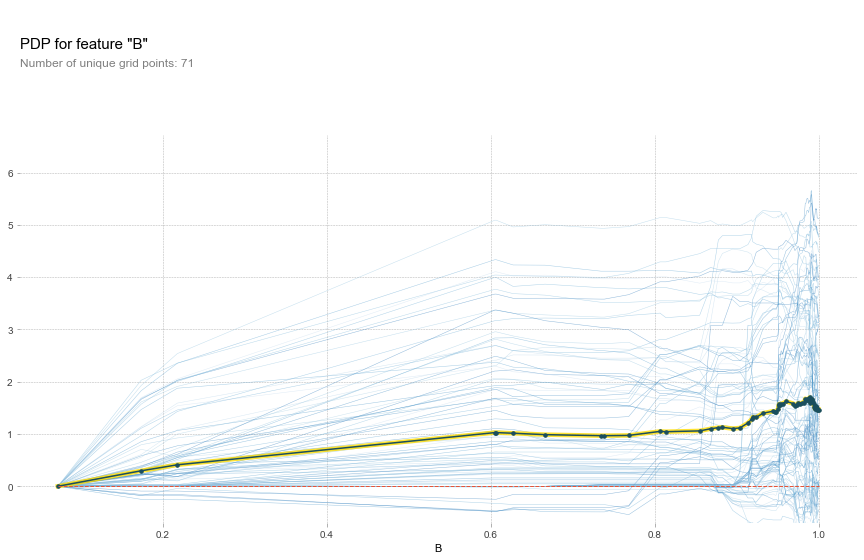

Adversarial PDP explanation:


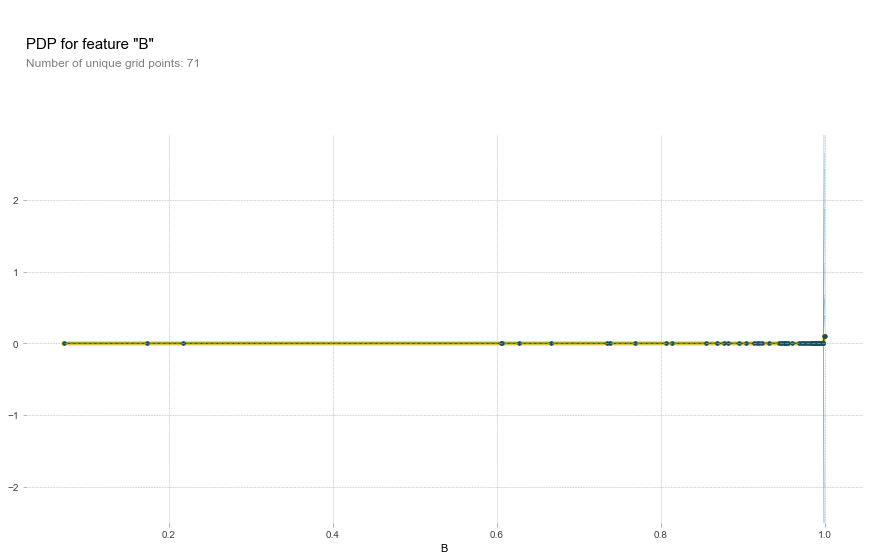

Prediction fidelity between original and adversarial model: 0.098


In [14]:
adv = AdversarialModelToolbox(biased_model=biased_ml,
                              x_train=x_train,
                              y_train=y_train, 
                              x_test=x_test, 
                              y_test=y_test,
                              input_feature_names=house_df.columns[input_ids].tolist(),
                              categorical_feature_indices=categorical_input_ids,
                              unbiased_model=unbiased_ml,
                              biased_id=biased_id, 
                              fool_explainer_type=ExplainerType.PDP,
                              ml_type=MLType.REGRESSION,
                              seed=SEED)
adv.train(perturbator=Perturbator(PerturbationMethod.GRID, perturb_index=biased_id, seed=SEED))
adv.get_explanations(explanation_sample_number=-1)